# Strict Dimers

In this notebook we count the number of strict dimers. Strict dimers are those pairs of particles which are close neighbors, and have one and only one close neighbor. A close neighbor is a neighbor which is closer than a threshold.


In [207]:
import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib.collections as clt
import pandas as pd
import string as st
import scipy.spatial as spp
import scipy.optimize as spo
import sympy as smp
import copy as cp
import pickle
import os
import sys

from IPython.display import HTML, clear_output

smp.init_printing()
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Where is the data?

In [209]:
dirc = 'Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_0/'
base_names = [os.path.join(root,os.path.splitext(file)[0]) 
              for root, dirs, files in os.walk(dirc) 
              for file in files 
              if file.endswith(".p")]

In [249]:
base_names[1]

'Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_1/exp_1\\field_6'

In [251]:
sim = pickle.load(open(base_names[1]+".p", "rb" ))
trj = lmp.trj_lazyread(base_names[1]+".lammpstrj")[0::100]
dim = lmp.dimers(trj, sim, distance=3)
dim = lmp.dimers_findpositions(dim,trj,sim)

anim = lmp.animate_dim(dim,sim,start=0,end=120,step=1,speedup=15)
HTML(anim.to_html5_video())

# Extract the strict dimers from the dimer database

We extract the id's of the dimers present within a range of frames. We should iterate only through these id's, since a dimer id is a direct mapping to the pair of particle which form the dimer. That is, once a pair of particles form a dimer, and an id is assigned, it will only be assigned to that pair of particles. It is however possible that a pair of particles has more than one id (for example if the dimer is broken, and then reformed). Changing this might improve the dimer defintitions.

Notice that if two different dimers contain the same particle, these can still be a strict dimer if they exist in different frames.

To extract the strict dimers from a set of dimers, the procedure is: 
        
        for each dimer:
            timespan is the collection of frames where the dimer exists
            for each other dimer in the same timespan:
                if the other dimer and dimer have a member in common:
                    save all frames where they coexist (as third_neighbors)
        
        concatenate all third_neighbors
        mark all third_neighbors as not strict
                

In [252]:
%%time

def strict_dimers(dim):
    """ Marks those dimers that are not strict as non_strict. """
    idx = pd.IndexSlice

    frames = dim.index.get_level_values("frame").unique().values
    dim_ids = dim.loc[idx[frames[::]]].index.get_level_values("id").unique().values

    not_strict = np.array([],dtype=[("frame",'i'),("id",'f')])

    for i,d_id in enumerate(dim_ids):
        
        members = dim.loc[idx[:,d_id],"members"].iloc[0]
        
        """ timespan is the set of frames where the dimer d_id exists""" 
        timespan = dim.loc[idx[:,d_id],:].index.get_level_values("frame").unique().values
        """ coexisting is an array of all the dimers that exist in the same timespan"""
        coexisting = dim.loc[idx[tuple(timespan),np.delete(dim_ids,i)],"members"]
        
        third_neighbors = np.array([index for dimer,index in zip(coexisting,coexisting.index) 
                                    if bool(dimer.intersection(members))],dtype=[("frame",'i'),("id",'f')])
        
        not_strict = np.append(not_strict,third_neighbors)

    not_strict = pd.DataFrame(not_strict)
    not_strict = not_strict.set_index(["frame","id"])

    dim["strict"] = True
    dim.loc[dim.index.intersection(not_strict.index),'strict']=False
    
    return dim

dim = strict_dimers(dim)

Wall time: 3.21 s


In [253]:
anim = lmp.animate_dim(dim[dim.strict==True],sim,start=0,end=120,step=1,speedup=15)
HTML(anim.to_html5_video())

# Number of strict dimers as function of field

### For ordered initial conditions

In [199]:
def count_strict_end(file):
    clear_output(wait=True)
    print("processing ", file)
    sim = pickle.load(open(file+".p", "rb" ))
    trj = lmp.trj_lazyread(file+".lammpstrj")[-1]
    dim = lmp.dimers(trj, sim, distance=3)
    dim = lmp.dimers_findpositions(dim,trj,sim)
    strict_dimers(dim)
    return sum(dim.strict.values), sim.field_parameters.magnitude

In [225]:
S,f = zip(*[count_strict_end(file) for file in base_names])

processing  Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_0/exp_9\field_20


In [228]:
Count = pd.DataFrame(index=np.array(f),data={"DimerCount":np.array(S)})
Count.index.name="field"
Count.to_csv("DimerCount_singleframe_Statistics_not_random.dat",sep="\t")

In [237]:
CountO = pd.read_csv("DimerCount_singleframe_Statistics_not_random.dat",sep="\t",index_col="field")

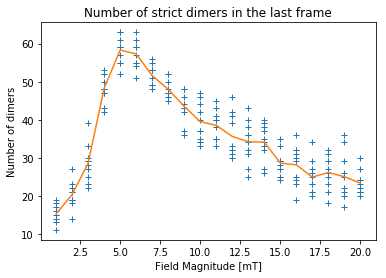

In [238]:
MeanCountO = CountO.groupby('field').mean()

plt.plot(CountO.index,CountO.DimerCount,'+')
plt.plot(MeanCountO.index,MeanCountO.DimerCount)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Number of dimers")
plt.title("Number of strict dimers in the last frame")

### For random boundary conditions

In [230]:
dirc = 'Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_1/'
base_names = [os.path.join(root,os.path.splitext(file)[0]) 
              for root, dirs, files in os.walk(dirc) 
              for file in files 
              if file.endswith(".p")]

In [231]:
S,f = zip(*[count_strict_end(file) for file in base_names])
Count = pd.DataFrame(index=np.array(f),data={"DimerCount":np.array(S)})
Count.index.name="field"
Count.to_csv("DimerCount_singleframe_Statistics_random.dat",sep="\t")

processing  Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_1/exp_9\field_20


In [235]:
CountR = pd.read_csv("DimerCount_singleframe_Statistics_random.dat",sep="\t",index_col="field")

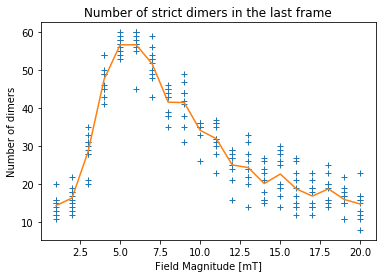

In [236]:
MeanCountR = CountR.groupby('field').mean()

plt.plot(CountR.index,CountR.DimerCount,'+')
plt.plot(MeanCountR.index,MeanCountR.DimerCount)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Number of dimers")
plt.title("Number of strict dimers in the last frame")

## Comparison

In [243]:
MeanOrderO = CountO.groupby('field').mean()
StdErrCountO = CountO.groupby('field').std()/np.sqrt(CountO.groupby('field').count())

MeanCountR = CountR.groupby('field').mean()
StdErrCountR = CountR.groupby('field').std()/np.sqrt(CountR.groupby('field').count())

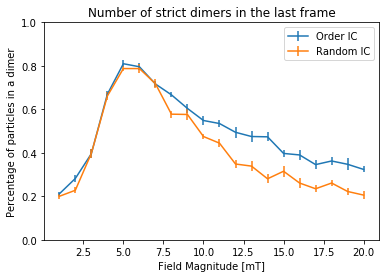

In [248]:
n_of_particles = 144/2

plt.errorbar(MeanCountO.index,MeanCountO.DimerCount/n_of_particles,StdErrCountO.DimerCount/n_of_particles)
plt.errorbar(MeanCountR.index,MeanCountR.DimerCount/n_of_particles,StdErrCountR.DimerCount/n_of_particles)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Percentage of particles in a dimer")
plt.title("Number of strict dimers in the last frame")
plt.legend({"Random IC", "Order IC"})
plt.ylim(0,1)
